In [1]:
  #import libraries 
    
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import datetime as dt
import re  
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
# import datasets to be used

issued=pd.read_csv('Building_Permits_Issued.csv',low_memory=False)
SINGLE_FAMILY_2009=pd.read_csv('2009 single family_final_with_sqft.txt')
SINGLE_FAMILY_2013=pd.read_csv('2013 single family_final_with_sqft.txt')
SINGLE_FAMILY_2017=pd.read_csv('2017 single family_final_with_sqft.txt')

In [3]:
# check what the data looks likes

issued.head()

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Const. Cost,Address,City,State,Zip,Subdivision/Lot,Contact,Permit Type,Permit Subtype,IVR Trk#,Purpose,Council Dist,Census Tract,Mapped Location
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,37208,UNIT A 1017 MONROE,"TRISTAR CONSTRUCTION, INC",CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740..."
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,37203,N W CORNER WEST END AVE & 23RD AVE N,Music City Tents & Events Llc,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14..."
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,37211,PT LOT 2 PATTERSON SUB,BOZMAN SIGN CO INC,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3..."
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,37076,UNIT 139 STONERS GLEN PHASE 1,"MR ROOF NASHVILLE, LLC",CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36...."
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,37203,LOT 1 O.B. HAYES FIRST PLAN CONSOLIDATION OF L...,Construction Enterprises Inc,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074..."


In [4]:
issued=issued.rename(columns={'Permit #': 'PermitNo', 'Permit Type Description':'PermTypeDesc', 'Permit Subtype Description': 'PermSubtypeDesc', 'Parcel':'Parcel', 'Date Entered':'Entered', 'Date Issued': 'Issued', 'Const. Cost': 'ConstCost', 'Address':'Address', 'City':'City', 'State':'State', 'Zip':'Zip', 'Subdivision/Lot': 'SubdLot', 'Contact':'Contact', 'Permit Type': 'PermType', 'Permit Subtype': 'PermSubtype', 'IVR Trk#': 'IVRTrk#', 'Purpose':'Purpose', 'Council Dist':'CouncilDist', 'Census Tract':'CensusTract', 'Mapped Location':'MappedLoc'})

In [5]:
#BuildingPermit['long_lat']=
# BuildingPermit['Mapped Location'].replace('\(.*?\)','',regex=True)


coords=re.compile(r'\(.*?\)')
matches = []
for string in issued.MappedLoc:
   match=re.findall(coords,string)
   matches.append(match)


In [6]:
# matches

In [7]:
matches=pd.DataFrame(matches)


In [8]:
matches.head()

,0,1
0,"(36.174077, -86.797183)",None
1,"(36.148736, -86.804731)",None
2,"(36.112749, -86.746151)",None
3,"(36.196166, -86.60253)",None
4,"(36.147074, -86.793734)",None


In [9]:
# keep only first column
matches=matches.iloc[:,0]



In [10]:
issued=issued.join(matches)

In [11]:
# rename column '0' as 'location'
issued.rename(columns={0:'location'},inplace =True)
issued.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,SubdLot,Contact,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,...,UNIT A 1017 MONROE,"TRISTAR CONSTRUCTION, INC",CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740...","(36.174077, -86.797183)"
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,...,N W CORNER WEST END AVE & 23RD AVE N,Music City Tents & Events Llc,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14...","(36.148736, -86.804731)"
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,...,PT LOT 2 PATTERSON SUB,BOZMAN SIGN CO INC,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3...","(36.112749, -86.746151)"
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,...,UNIT 139 STONERS GLEN PHASE 1,"MR ROOF NASHVILLE, LLC",CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36....","(36.196166, -86.60253)"
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,...,LOT 1 O.B. HAYES FIRST PLAN CONSOLIDATION OF L...,Construction Enterprises Inc,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074...","(36.147074, -86.793734)"


In [12]:
# remove the parenthesis
issued['location']=issued.location.str.replace('(','')

In [13]:
issued['location']=issued.location.str.replace(')','')


In [14]:
# split by strings by comma and assign them to latitude and longitude
location=issued.location.str.split(', ', expand=True)

In [15]:
location.rename(columns={0:'Lat',1:'Long'},inplace=True)


In [16]:
issued_df=issued.join(location)

In [17]:
issued_df.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location,Lat,Long
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,...,CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740...","36.174077, -86.797183",36.174077,-86.797183
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,...,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14...","36.148736, -86.804731",36.148736,-86.804731
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,...,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3...","36.112749, -86.746151",36.112749,-86.746151
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,...,CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36....","36.196166, -86.60253",36.196166,-86.60253
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,...,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074...","36.147074, -86.793734",36.147074,-86.793734


In [18]:
# drop unneccessary column 
#issued_df=issued_df.drop('location',axis=1)

In [19]:
#issued_df['Long']=pd.to_numeric(issued_df['Long'])

In [20]:
#issued_df['Lat']=pd.to_numeric(issued_df['Lat'])

In [21]:
#  split the location column  by comma
# issued['lat']=issued.location.str.split(',')

In [22]:
# covert Issued date column to datetime format and create a year column from the Issued date
issued['Issued']=pd.to_datetime(issued.Issued)

# create Year column
issued['Year']=issued['Issued'].dt.year

In [23]:
# check data type of location column
issued.location.dtype

dtype('O')

In [24]:
# look what the data looks like
# Land: Land value
# IMPR: Improvement Values
# Total APPR: Total Appraised value 

SINGLE_FAMILY_2009.head()

sf2009=SINGLE_FAMILY_2009.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2009 LAND':'LandValue', '2009 IMPR':'ImprovementValue', '2009 TOTAL APPR':'AppraisedValue', '2009 TOTAL ASSD':'2009 TOTAL ASSD'})

In [25]:
# to check if there are zero values
sf2009.LandValue.min()

0.0

In [26]:
# rename column names
sf2013=SINGLE_FAMILY_2013.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2013 LAND':'LandValue', '2013 IMPR':'ImprovementValue', '2013 TOTAL APPR':'AppraisedValue', '2013 TOTAL ASSD':'2013 TOTAL ASSD'})

sf2017=SINGLE_FAMILY_2017.rename(columns={'APN':'APN', 'DistrictCode':'DistrictCode', 'Council District':'DistrictNo', 'AddressFullAddress': 'Address', 'AddressCity':'City', 'AddressPostalCode':'Zip', '2017 LAND':'LandValue', '2017 IMPR':'ImprovementValue', '2017 TOTAL APPR':'AppraisedValue', '2017 TOTAL ASSD':'2017 TOTAL ASSD'})


In [27]:
Lat_Long_Zip=pd.read_csv('US Zip Codes from 2013 Government Data')
Lat_Long_Zip.rename(columns={'zipcode':'Zip'},inplace=True)
Lat_Long_Zip.rename(columns={'ZIP':'Zip'},inplace=True)

In [28]:
# merge zip code data with 2009,213,2015,2017
sf2009=pd.merge(Lat_Long_Zip,sf2009,'inner',on='Zip')
sf2013=pd.merge(Lat_Long_Zip,sf2013,'inner',on='Zip')
sf2017=pd.merge(Lat_Long_Zip,sf2017,'inner',on='Zip')

In [29]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0


In [30]:
sf2013.AppraisedValue.dtype


dtype('float64')

In [31]:
sf2013.AppraisedValue.mean()

201045.38607068273

In [32]:
# morgage formula
# P = L[r(1 + r)m]/[(1 + r)m - 1], P=monthly payment,r=interest rate per month,m =number of months
r=0.0475/12 # monthly interest rate
m=30*12 # number of months in 30 years

# calculate yearly spending 
sf2013['Yearly_Housing_Spending']=12*(sf2013.AppraisedValue-sf2013.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)
sf2009['Yearly_Housing_Spending']=12*(sf2009.AppraisedValue-sf2009.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)
sf2017['Yearly_Housing_Spending']=12*(sf2017.AppraisedValue-sf2017.AppraisedValue*0.05)*(r*(1+r)**m)/((1+r)**m-1)

In [33]:
sf2013['Yearly_Housing_Spending'].head()

0    6386.841329
1    7076.667767
2    8129.247763
3    7142.082343
4    7029.093530
Name: Yearly_Housing_Spending, dtype: float64

In [34]:
sf2013_Zip=sf2013.loc[:,['Zip','Yearly_Housing_Spending']]

# 2013 Highest Housing Spending Zip Codes

* zip code 37205 and 37215 are top two highest housing spending areas(highest valued areas)
* These two zip codes are in  the South Nashville 
* https://goo.gl/maps/G4b3xSGxrP12
*  https://goo.gl/maps/eep7Z48U1R12

In [35]:
# calculate mean morgage by zip codes
sf2013_Zip.groupby('Zip').mean().sort_values('Yearly_Housing_Spending',ascending=False)
# top 10 highest morgage zip codes
highest_morgage_Zip=sf2013_Zip.groupby('Zip').mean().sort_values('Yearly_Housing_Spending',ascending=False).head(10)
highest_morgage_Zip

,Yearly_Housing_Spending
Zip,
37205,31724.581034
37215,31484.935750
37220,26345.276642
37064,22626.144975
37204,20762.806214
37212,19339.271509
37027,18335.485495
37135,15642.979659
37086,15265.383326


# 2013 lowest Housing Spending Zip Codes

* Majority of low valued/low spending areas are in East Nashville and Antioch
* zip code 37228 has the lowest yearly housing spending/morgage payment
*  which is located in North Nashville mainly warehouse areas
* https://goo.gl/maps/oHs6b7oFQQT2 

In [36]:
# bottom 10 morgage zip codes
lowest_morgage_Zip=sf2013_Zip.groupby('Zip').mean().sort_values('Yearly_Housing_Spending',ascending=False).tail(10)
lowest_morgage_Zip


,Yearly_Housing_Spending
Zip,
37214,7935.384170
37013,7782.564163
37015,7618.493727
37218,7106.900387
37115,6965.993639
37217,6598.035925
37210,6237.865671
37208,5994.471421
37207,5960.014089


In [37]:
sf2013_map=sf2013
sf2013['geometry'] = sf2013.apply(lambda x: Point((float(x.LNG), float(x.LAT))), axis=1)
sf2013_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186269 entries, 0 to 186268
Data columns (total 15 columns):
Zip                        186269 non-null int64
LAT                        186269 non-null float64
LNG                        186269 non-null float64
APN                        186269 non-null object
DistrictCode               186269 non-null object
DistrictNo                 186269 non-null int64
Address                    186269 non-null object
City                       186269 non-null object
LandValue                  186269 non-null float64
ImprovementValue           186269 non-null float64
AppraisedValue             186269 non-null float64
2013 TOTAL ASSD            186269 non-null float64
FinishedArea               186269 non-null float64
Yearly_Housing_Spending    186269 non-null float64
geometry                   186269 non-null object
dtypes: float64(8), int64(2), object(5)
memory usage: 22.7+ MB


In [38]:
# let's check type of permit

issued.loc[:,['PermTypeDesc','PermSubtypeDesc','PermType']].head()

,PermTypeDesc,PermSubtypeDesc,PermType
0,Building Residential - New,Single Family Residence,CARN
1,Building Use & Occupancy,"Tents, Stages",CAUO
2,Building Sign Permit,Sign - Ground / Wall Signs,CASN
3,Building Residential - Roofing / Siding,Duplex,CARK
4,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",CART


In [39]:
issued.PermType.unique()

array(['CARN', 'CAUO', 'CASN', 'CARK', 'CART', 'CARR', 'CACK', 'CACF',
       'CACR', 'CACN', 'CACA', 'CADM', 'CACT', 'CARA', 'CARH', 'CARJ',
       'CATR', 'CACH', 'CABL', 'CARF', 'CARE', 'CARP', 'CACG', 'CACJ',
       'CARW', 'CAMV', 'CACP', 'CARL', 'CACE', 'CACL'], dtype=object)

In [40]:
# to calculate how many permits issued per year?

issued_select1= issued.loc[:,['Year','PermitNo','PermTypeDesc','PermSubtypeDesc','Issued','ConstCost','Zip']]

In [41]:
issued_select2=issued_select1.loc[:,['Year','Zip','PermitNo']]


In [42]:
issued_select2.head()

,Year,Zip,PermitNo
0,2018,37208,2018002927
1,2016,37203,201617929
2,2016,37211,2016049270
3,2016,37076,2016029907
4,2015,37203,201533533


- Zip 37209 in 2017 has the highest number of permits issued

In [43]:
# find count of issued permits by zip code and year

issued_zip_yearly=issued_select2.groupby(['Zip','Year']).count()

issued_zip_yearly.rename(columns={'PermitNo':'count'},inplace=True)
issued_zip_yearly.sort_values('count',ascending=False).head()

count
Zip   Year       
37209 2017   1346
      2016   1329
37203 2016   1051
37206 2016   1014
37209 2018    938

In [44]:
# count number of building permits issued per year
issued_yearly=issued_select2.groupby('Year').count()
issued_yearly.rename(columns={'PermitNo':'count'},inplace=True)
issued_yearly.sort_values('count',ascending=False)

,Zip,count
Year,,
2016,12533,12533
2017,11624,11624
2018,8011,8011
2015,4053,4053


In [45]:
# the average construction cost $289901.5

In [46]:
# compute desctiptive statistics for coonstruction cost

issued_select1.ConstCost.describe()

count    3.608500e+04
mean     2.899015e+05
std      1.933948e+06
min      0.000000e+00
25%      7.637000e+03
50%      5.000000e+04
75%      2.144000e+05
max      8.809536e+07
Name: ConstCost, dtype: float64

In [47]:
2.899015*(10**5)

289901.5

In [48]:
# find residential permits
residential=(issued.loc[issued['PermType'].isin(['CARN','CARR'])])

In [49]:
residential_Zip_Yearly=residential.loc[:,['Year','Zip','PermitNo']]

In [50]:
residential_Zip_Yearly.head()

,Year,Zip,PermitNo
0,2018,37208,2018002927
5,2016,37215,201605753
6,2017,37216,2017032777
7,2015,37221,201546095
11,2016,37209,201605693


- 37209, 37206 and 37013 are the top 3 zip codes where highest number of residential permits were issued.

In [51]:
# residential permits by zip code by year
residential_Zip_Year=residential_Zip_Yearly.groupby(['Zip','Year']).count()
residential_Zip_Year.sort_values('PermitNo',ascending=False)

PermitNo
Zip   Year          
37209 2017       777
      2016       767
37206 2016       603
37013 2017       589
      2016       560
37209 2018       554
37013 2018       422
37207 2017       413
37206 2017       382
37208 2017       364
      2016       362
37216 2016       345
37207 2016       339
37076 2017       300
37207 2018       297
37215 2016       273
37216 2017       273
37203 2016       272
37221 2016       270
37208 2018       269
37211 2016       269
37209 2015       262
37076 2016       249
37203 2017       237
37135 2017       230
37211 2017       220
37221 2017       219
37206 2018       211
37205 2017       204
37211 2018       203
...              ...
37072 2018        17
37214 2015        17
37122 2015        16
37080 2016        16
37072 2015        11
37218 2015        11
37189 2016        11
37220 2015         8
37080 2015         7
37064 2017         5
37201 2015         5
0     2017         4
37143 2018         4
      2016         3
37189 2015         3
37219 2016         3
37201 2016         3
37015 2016         2
37122 2016         2
      2017         2
37143 2015         2
      2017         2
0     2016         1
37201 2018         1
      2017         1
37200 2017         1
37064 2018         1
37015 2018         1
      2017         1
37228 2016         1

[125 rows x 1 columns]

In [52]:
residential_Yearly=residential.loc[:,['Year','PermitNo']]


In [53]:
residential_by_year=residential_Yearly.groupby('Year').count()


In [54]:
residential_by_year_sorted=residential_by_year.sort_values('PermitNo',ascending=False)
residential_by_year_sorted

,PermitNo
Year,
2016,5719
2017,5531
2018,3840
2015,1944


Text(0.5,1,'Number of permits issued between 2015-2018')

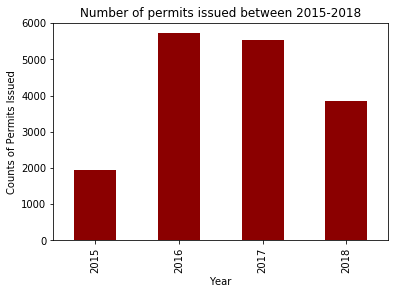

In [55]:
residential_by_year.plot(kind='bar',color='darkred',legend=False)
plt.ylabel('Counts of Permits Issued')
plt.title('Number of permits issued between 2015-2018')

# The average cost for residential permits has been decreasing since 2015.

In [56]:
# construction cost by year residential permits
residential_select1=residential.loc[:,['Year','ConstCost']]
residential_select1=residential_select1.groupby('Year').mean().sort_values('ConstCost',ascending=False)
residential_select1

,ConstCost
Year,
2015,246624.092593
2016,217071.623229
2017,169297.173480
2018,160449.615625


Text(0.5,1,'Average Cost of Construction Overtime')

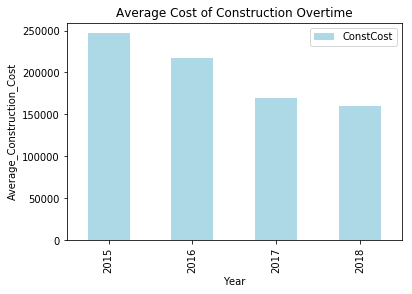

In [57]:
residential_select1.plot(kind='bar',color='lightblue')
plt.ylabel('Average_Construction_Cost')
plt.title('Average Cost of Construction Overtime')

In [58]:
# demo_residential=issued[(residential.Address) ISIN (demolished.Address)]

In [59]:
# find demolished permits
demolished=(issued.loc[issued['PermType']=='CADM'])
demolished.head()

,PermitNo,PermTypeDesc,PermSubtypeDesc,Parcel,Entered,Issued,ConstCost,Address,City,State,...,Contact,PermType,PermSubtype,IVRTrk#,Purpose,CouncilDist,CensusTract,MappedLoc,location,Year
23,201543896,Building Demolition Permit,Demolition Permit - Residential,10509038300,10/08/2015,2015-10-08,4000.0,914 ACKLEN AVE,NASHVILLE,TN,...,Graham Construction Of Tennessee Llc,CADM,CAZ01A001,2075785,Work on this demolition permit must commence w...,17.0,37016200.0,"914 ACKLEN AVE\nNASHVILLE, TN 37203\n(36.13354...","36.133549, -86.783616",2015
30,201620413,Building Demolition Permit,Demolition Permit - Residential,08116022300,05/03/2016,2016-05-03,5000.0,918 SCOVEL ST,NASHVILLE,TN,...,K Jordan Construction Llc,CADM,CAZ01A001,2120019,Work on this demolition permit must commence w...,19.0,37019400.0,"918 SCOVEL ST\nNASHVILLE, TN 37208\n(36.173632...","36.173632, -86.794535",2016
36,201614474,Building Demolition Permit,Demolition Permit - Residential,13102006500,03/31/2016,2016-03-31,7500.0,1923 WARFIELD DR,NASHVILLE,TN,...,Cat3 Restoration Llc,CADM,CAZ01A001,2112314,to demolish exisitng single family residence. ...,25.0,37017901.0,"1923 WARFIELD DR\nNASHVILLE, TN 37215\n(36.102...","36.102592, -86.813442",2016
37,2016039565,Building Demolition Permit,Demolition Permit - Residential,10200007600,08/03/2016,2016-08-03,21000.0,3985 OLD HICKORY BLVD,NASHVILLE,TN,...,SELF CONTRACTOR COMMERCIAL (SEE APPLICANT INFO...,CADM,CAZ01A001,3264459,to demolish existing single family residence. ...,1.0,37013100.0,"3985 OLD HICKORY BLVD\nNASHVILLE, TN 37218\n(3...","36.146926, -86.903582",2016
47,2017033484,Building Demolition Permit,Demolition Permit - Residential,15900008000,05/19/2017,2017-05-19,10000.0,5610 GRANNY WHITE PIKE,BRENTWOOD,TN,...,"URBAN DEVELOPMENT GROUP, LLC",CADM,CAZ01A001,3368029,to demolish existing residence. not to be bur...,34.0,37018700.0,"5610 GRANNY WHITE PIKE\nBRENTWOOD, TN 37027\n(...","36.046438, -86.815953",2017


In [60]:
demolished_select1=demolished.loc[:,['Year','PermitNo','PermTypeDesc','PermSubtypeDesc','Issued','ConstCost','Zip']]

In [61]:
# see counts of demolishing permits issued by years and zip code
demolished_select2=demolished_select1.loc[:,['Year','Zip','PermitNo']]
demolished_select2=demolished_select2.groupby(['Zip','Year']).count()
demolished_select2.sort_values('PermitNo',ascending=False)

PermitNo
Zip   Year          
37209 2016       238
      2017       178
37206 2016       132
37209 2018       131
37203 2016       119
37208 2016       111
      2017       101
37215 2016        95
37206 2017        95
37216 2016        87
37203 2017        84
37215 2017        75
37207 2016        70
37208 2018        70
37207 2017        65
37209 2015        61
37206 2015        59
37204 2016        56
37215 2018        54
37204 2017        51
37205 2016        51
37216 2017        51
37203 2018        50
37205 2017        50
37203 2015        49
37115 2017        47
37207 2018        46
37212 2016        44
37206 2018        42
37211 2016        40
...              ...
37220 2016         3
37221 2015         3
0     2017         3
37013 2015         3
37189 2017         3
37027 2017         3
37080 2016         3
37076 2016         3
      2015         2
37201 2016         2
37027 2018         2
37217 2015         2
37219 2016         2
37072 2017         2
37064 2017         1
37221 2017         1
37015 2018         1
37220 2017         1
37219 2017         1
37214 2015         1
37072 2016         1
      2018         1
0     2018         1
37080 2017         1
37143 2016         1
      2018         1
37189 2015         1
      2016         1
37201 2018         1
37228 2017         1

[104 rows x 1 columns]

https://github.com/nss-data-science-cohort-2/data-question-4-affordable-housing-plaid-platypi-plaidypi.git


# income groups based on Area Median income(AMI) =$ 68K (for family of 4)
AMI=68000

income_cat_1=0.30* AMI
income_cat_2=60*AMI
income_cat_3=0.80*AMI
income_cat_4=1.20*AMI
income_cat_5>=1.20*AMI


# the families should not spend more than 30 % of their income in all categories
# where to find income data: census tract
# maximum spending on housing per each category

cat1_spend=68000*0.3*0.3
cat2_spend=68000*0.6*0.3
cat3_spend=68000*0.8*0.3
cat4_spend=68000*1.2*0.3




In [62]:
AMI=68000

income_cat_1=0.30* AMI
income_cat_2=0.60*AMI
income_cat_3=0.80*AMI
income_cat_4=1.20*AMI



In [63]:
print(income_cat_1)
print(income_cat_2)
print(income_cat_3)
print(income_cat_4)

20400.0
40800.0
54400.0
81600.0


In [64]:
cat1_spend=income_cat_1*0.3
cat2_spend=income_cat_2*0.3
cat3_spend=income_cat_3*0.3
cat4_spend=income_cat_4*0.3


In [65]:
print(cat1_spend)
print(cat2_spend)
print(cat4_spend)
print(cat4_spend)

6120.0
12240.0
24480.0
24480.0


In [66]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Yearly_Housing_Spending,geometry
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0,6386.841329,POINT (-86.632515 36.052231)
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0,7076.667767,POINT (-86.632515 36.052231)
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0,8129.247763,POINT (-86.632515 36.052231)
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0,7142.082343,POINT (-86.632515 36.052231)
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0,7029.093530,POINT (-86.632515 36.052231)


In [67]:
# create backets 
def backet(x):
    if x<=cat1_spend:
        return 'cat1_spending'
    elif x<=cat2_spend:
         return 'cat2_spending'
    elif x<=cat3_spend:
        return 'cat3_spending'
    elif x<=cat4_spend:
        return 'cat4_spending'
    else:
        return 'Cat5_spending'
     

In [68]:
# assing the backets to sf2013

sf2013['backets']=sf2013.Yearly_Housing_Spending.apply(backet)

sf2009['backets']=sf2009.Yearly_Housing_Spending.apply(backet)

sf2017['backets']=sf2017.Yearly_Housing_Spending.apply(backet)

In [69]:
sf2013.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Yearly_Housing_Spending,geometry,backets
0,37013,36.052231,-86.632515,135140A00100CO,USD,28,700 PICCADILLY ROW,ANTIOCH,27000.0,80400.0,107400.0,26850.0,1291.0,6386.841329,POINT (-86.632515 36.052231),cat2_spending
1,37013,36.052231,-86.632515,135140A00200CO,USD,28,704 PICCADILLY ROW,ANTIOCH,27000.0,92000.0,119000.0,29750.0,1491.0,7076.667767,POINT (-86.632515 36.052231),cat2_spending
2,37013,36.052231,-86.632515,135140A00300CO,USD,28,708 PICCADILLY ROW,ANTIOCH,27000.0,109700.0,136700.0,34175.0,1934.0,8129.247763,POINT (-86.632515 36.052231),cat2_spending
3,37013,36.052231,-86.632515,135140A00400CO,USD,28,712 PICCADILLY ROW,ANTIOCH,27000.0,93100.0,120100.0,30025.0,1559.0,7142.082343,POINT (-86.632515 36.052231),cat2_spending
4,37013,36.052231,-86.632515,135140A00500CO,USD,28,716 PICCADILLY ROW,ANTIOCH,27000.0,91200.0,118200.0,29550.0,1471.0,7029.093530,POINT (-86.632515 36.052231),cat2_spending


In [70]:
# backets for 2013
# create backet 1
sf2013_backet1=sf2013.loc[sf2013['backets']=='cat1_spending']
# create backet 2
sf2013_backet2=sf2013.loc[sf2013['backets']=='cat2_spending']
# create backet 3
sf2013_backet3=sf2013.loc[sf2013['backets']=='cat3_spending']
# create backet 4
sf2013_backet4=sf2013.loc[sf2013['backets']=='cat4_spending']
# create backet 5
sf2013_backet5=sf2013.loc[sf2013['backets']=='cat5_spending']

In [71]:
# backets for 2009
# create backet 1
sf2009_backet1=sf2009.loc[sf2009['backets']=='cat1_spending']
# create backet 2
sf2009_backet2=sf2009.loc[sf2009['backets']=='cat2_spending']
# create backet 3
sf2009_backet3=sf2009.loc[sf2009['backets']=='cat3_spending']
# create backet 4
sf2009_backet4=sf2009.loc[sf2009['backets']=='cat4_spending']
# create backet 5
sf2009_backet5=sf2009.loc[sf2009['backets']=='cat5_spending']

In [72]:
# backets for 2017

# create backet 1
sf2017_backet1=sf2017.loc[sf2017['backets']=='cat1_spending']
# create backet 2
sf2017_backet2=sf2017.loc[sf2017['backets']=='cat2_spending']
# create backet 3
sf2017_backet3=sf2017.loc[sf2017['backets']=='cat3_spending']
# create backet 4
sf2017_backet4=sf2017.loc[sf2017['backets']=='cat4_spending']
# create backet 5
sf2017_backet5=sf2017.loc[sf2017['backets']=='cat5_spending']

In [73]:
sf2013_backet1.head()

,Zip,LAT,LNG,APN,DistrictCode,DistrictNo,Address,City,LandValue,ImprovementValue,AppraisedValue,2013 TOTAL ASSD,FinishedArea,Yearly_Housing_Spending,geometry,backets
7,37013,36.052231,-86.632515,135140A00800CO,USD,28,1037 ALDERSGATE RD,ANTIOCH,27000.0,74100.0,101100.0,25275.0,1527.5,6012.194212,POINT (-86.632515 36.052231),cat1_spending
135,37013,36.052231,-86.632515,135140A13600CO,USD,28,509 BLACK MOUNTAIN CT,ANTIOCH,27000.0,67800.0,94800.0,23700.0,1504.5,5637.547095,POINT (-86.632515 36.052231),cat1_spending
141,37013,36.052231,-86.632515,135140A14200CO,USD,28,821 ROCKY MOUNTAIN PKWY,ANTIOCH,27000.0,68900.0,95900.0,23975.0,1519.0,5702.961671,POINT (-86.632515 36.052231),cat1_spending
273,37013,36.052231,-86.632515,135140C00200CO,USD,28,705 VANGUARD PL,ANTIOCH,27000.0,71200.0,98200.0,24550.0,1450.5,5839.737603,POINT (-86.632515 36.052231),cat1_spending
276,37013,36.052231,-86.632515,135140C00500CO,USD,28,717 VANGUARD PL,ANTIOCH,27000.0,75100.0,102100.0,25525.0,1554.0,6071.662008,POINT (-86.632515 36.052231),cat1_spending
